# Welcome to the LSBoosting Notebook for Folktables!

In this notebook, you'll be able to import US Census data from Folktables easily via the helper function and then train a LSBoostRegressor using your choice of hyperparameters!

### Install/Imports

In [1]:
# pip install scikit-learn
# pip install tqdm
# pip install pandas
# pip install seaborn
# pip install folktables

In [2]:

import LSBoost
# from LSBoost import LSBoostingRegressor
import helper_functions as hf

import pandas as pd

import numpy as np

import sklearn as sk
from sklearn.model_selection import train_test_split
from helper_functions import MSCE as MSCE
from sklearn.metrics import mean_squared_error as MSE

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression

import gc
import time
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

/home/ralur/miniconda3/envs/heap/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
X = pd.read_csv('./visual-prediction-data/features_labels_wide.csv')
h = pd.read_csv('./visual-prediction-data/study_2/responses.csv')

In [4]:
data = X.drop(['escaped', 'location', 'room'], axis=1)
escaped = X['escaped'].map({'Y': 1, 'N': 0})


In [5]:
data.head()

,file_id,location_boston,location_arizona,location_texas,location_nyc,room_theater,room_dig,room_office,room_home,room_apartment,...,p_glass,race_NA,race_asian,race_black,race_white,race_entropy,smile_coef_mean,smile_coef_median,smile_coef_std,confidence
0,1010227249025169,1,0,0,0,0,0,1,0,0,...,0.0,3,0,0,7,0.0,54.961,70.882,33.650,2
1,969078203140074,1,0,0,0,0,0,1,0,0,...,0.0,4,0,0,8,0.0,87.983,95.030,17.712,1
2,906142969433598,1,0,0,0,0,0,0,0,0,...,0.4,0,0,0,5,0.0,58.330,74.165,24.595,5
3,880673725313856,1,0,0,0,0,0,0,0,0,...,0.0,2,0,0,5,0.0,52.075,43.388,20.601,5
4,965696076811620,1,0,0,0,0,0,1,0,0,...,0.0,0,0,0,10,0.0,88.929,93.034,10.039,3


In [6]:
random_state = 0
np.random.seed(random_state)


x_train = data[~data['file_id'].isin(h['Img'])]
y_train = escaped[~data['file_id'].isin(h['Img'])]

x_test = data[data['file_id'].isin(h['Img'])]
y_test = escaped[data['file_id'].isin(h['Img'])]


x_train_id = x_train['file_id']
x_train = x_train.drop(['file_id'], axis = 1)
x_test_id = x_test['file_id']
x_test = x_test.drop('file_id', axis = 1)



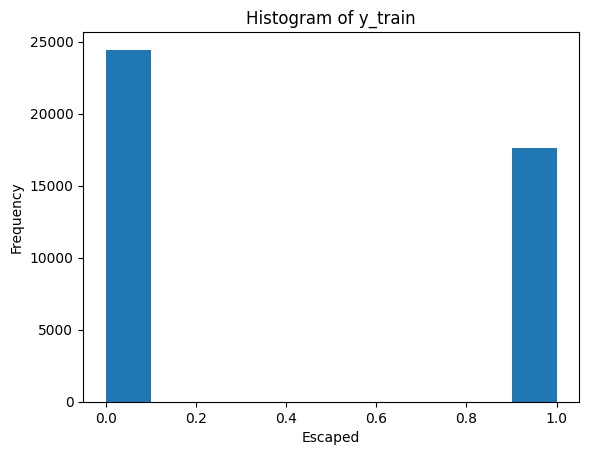

In [7]:
# plot histogram of y_train
import matplotlib.pyplot as plt

plt.hist(y_train)
plt.xlabel('Escaped')
plt.ylabel('Frequency')
plt.title('Histogram of y_train')
plt.show()

In [8]:
x_train.head()

,location_boston,location_arizona,location_texas,location_nyc,room_theater,room_dig,room_office,room_home,room_apartment,room_agency,...,p_glass,race_NA,race_asian,race_black,race_white,race_entropy,smile_coef_mean,smile_coef_median,smile_coef_std,confidence
0,1,0,0,0,0,0,1,0,0,0,...,0.0,3,0,0,7,0.0,54.961,70.882,33.650,2
1,1,0,0,0,0,0,1,0,0,0,...,0.0,4,0,0,8,0.0,87.983,95.030,17.712,1
2,1,0,0,0,0,0,0,0,0,0,...,0.4,0,0,0,5,0.0,58.330,74.165,24.595,5
3,1,0,0,0,0,0,0,0,0,0,...,0.0,2,0,0,5,0.0,52.075,43.388,20.601,5
4,1,0,0,0,0,0,1,0,0,0,...,0.0,0,0,0,10,0.0,88.929,93.034,10.039,3


### Data Control Panel

### Hyperparameter Tuning

In [9]:
# number of rounds - (integer)
T = 100

# level sets - (integer)
num_bins = 10

# minimum number of points in level set for update to occur - (integer)
min_group_size = 5

# amount (multiplicative) level set must improve by to accept update if validation data or leniency factor for update requirements - (float)
global_gamma = .01

# weak learner class for UDT - (ML class with .predict method)
weak_learner = DecisionTreeRegressor(max_depth=5)

# determines width of level sets, either 'default' for equal width or 'distribution' for equal number of expected points - (string)
bin_type = 'default'

# multiplicative weight for new update - (float)
learning_rate = 1

# starting model to boost. Set to None for weak learner to be use as initial model - (fit ML class with .predict method or None)
initial_model = None

# round final predictions to level set center or use output of weak learner - (bool)
final_round = False

# center level sets using historical mean - (bool)
center_mean = False

### Train LSBoost Regressor

In [10]:
LSBoostReg = LSBoost.LSBoostingRegressor(
                                T = T, 
                                num_bins = num_bins, 
                                min_group_size = min_group_size, 
                                global_gamma = global_gamma, 
                                weak_learner= weak_learner, 
                                bin_type = bin_type, 
                                learning_rate = learning_rate, 
                                initial_model = initial_model,  
                                final_round = final_round, 
                                center_mean=center_mean)
LSBoostReg.fit(x_train.values, y_train.values)

LS:  35%|███▌       35/100 00:24, Training Error=0.0091150

Early Termination at round: 36
Memory released!


### Predict on train/test data and print MSE/MSCE on train/test

In [11]:
print(f'Number of weak learner updates made: {LSBoostReg.updates} \n')


test_predictions = LSBoostReg.predict(x_test.values)
print(f'Test Accuracy: {np.mean((y_test == (test_predictions >= .5))):.6f}\n')
test_cor = np.corrcoef(test_predictions, y_test)
print(f'Test Correlation: {test_cor[0][1]:.6f}\n')

Number of weak learner updates made: 378 

Test Accuracy: 0.722115

Test Correlation: 0.389033



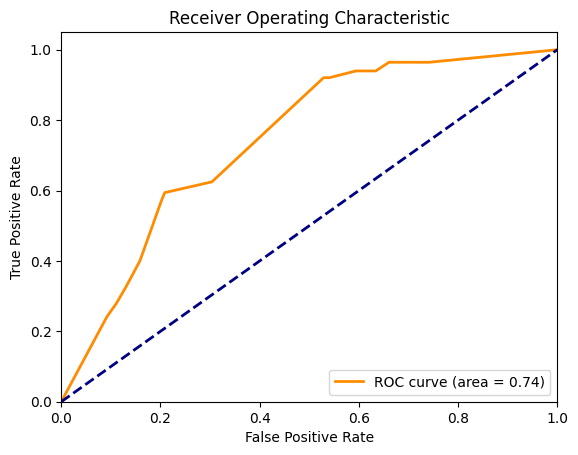

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, test_predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



In [13]:
bins = np.ceil(test_predictions * num_bins).astype(int)
df = pd.DataFrame({'file_id': x_test_id, 'mc_pred': test_predictions, 'bin': bins})
df.to_csv('./mc_predictions.csv', index=False)


In [14]:
df['bin'].unique()

array([10,  0,  1])